# **OptiRoute Pune**

### Phase 1 – Data Ingestion from OSM

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

In [2]:
place_name= "Pune, India"
graph= ox.graph_from_place(place_name, network_type='drive')        #Used network_type='drive' for drivable roads only
graph= ox.project_graph(graph)      ##transforms the original graph into a projected format, allowing for accurate spatial analysis and distance calculations

### Phase 2 – Route Optimization

**Type of Highways in the Dataset:**
[residential, trunk, tertiary, secondary, ['residential', 'secondary'] primary, primary_link, living_street, ['residential', 'living_street'], trunk_link, secondary_link, ['trunk_link', 'trunk'], busway, tertiary_link, unclassified, ['secondary_link', 'secondary'], ['residential', 'tertiary'], road, ['primary_link', 'primary'], ['primary', 'trunk'], ['tertiary', 'secondary'], ['unclassified', 'tertiary'], ['residential', 'unclassified'], ['unclassified', 'residential']]

In [3]:
#Normalize highway tags
def normalize_highway_tags(G):
    for u, v, k, d in G.edges(keys=True, data=True):
        hwy= d.get("highway", "unclassified")

        if isinstance(hwy, list):
            hwy= hwy[-1]        #keep the last element
        d["highway"]= hwy
    return G

graph= normalize_highway_tags(graph)

**Mapping of Highway Type → Assumed Average Speed (km/h)**
| Highway type                  | Real-world reasoning                                      |
| ----------------------------- | --------------------------------------------------------- |
| **motorway** (expressway)     | Should allow 80–100, but in city limits it averages \~60. |
| **motorway\_link**            | Ramps/connecting roads, more merging → \~45.              |
| **trunk** (major city artery) | Heavily used, lots of signals → \~35.                     |
| **primary**                   | Main city roads, \~30.                                    |
| **secondary**                 | Sub-arterial, \~25.                                       |
| **tertiary**                  | Smaller through-roads, \~20.                              |
| **residential**               | Narrow, parked vehicles, \~15.                            |
| **unclassified**              | Often same as residential.                                |
| **living\_street**            | Pedestrian-friendly lanes, \~8.                           |
| **service**                   | Parking lots, service lanes, \~10.                        |
| **busway**                    | Sometimes dedicated → 25.                                 |
| **road**                      | Catch-all, assumed \~15.                                  |

In [4]:
# asummed speed mapping for the roads
urban_speeds_kph = {
    "motorway": 60, "motorway_link": 45,
    "trunk": 35, "trunk_link": 30,
    "primary": 30, "primary_link": 25,
    "secondary": 25, "secondary_link": 22,
    "tertiary": 20, "tertiary_link": 18,
    "residential": 15, "unclassified": 15,
    "living_street": 8, "service": 10,
    "busway": 25, "road": 15
}

graph= ox.add_edge_speeds(graph, hwy_speeds= urban_speeds_kph)
graph= ox.add_edge_travel_times(graph)

Now every edge has:
- length (meters)
- speed_kph (from mapping)
- travel_time (seconds)

In [5]:
# Export nodes and edges
nodes, edges= ox.graph_to_gdfs(graph)

In [6]:
ox.save_graphml(graph, filepath="data/pune_drive.graphml")
nodes.to_csv("data/pune_nodes.csv", index=False)
edges.to_csv("data/pune_edges.csv", index=False)

In [7]:
#Checking if highways are normalized and speeds exist
unique_hwy= set(edges["highway"].unique())
print("Unique highways after normalization", unique_hwy)

missing_speed= edges[edges["speed_kph"].isna()]
print("Edges missing speed mapping:", len(missing_speed))

Unique highways after normalization {'trunk', 'primary', 'busway', 'trunk_link', 'living_street', 'unclassified', 'secondary_link', 'road', 'residential', 'secondary', 'primary_link', 'tertiary_link', 'tertiary'}
Edges missing speed mapping: 0


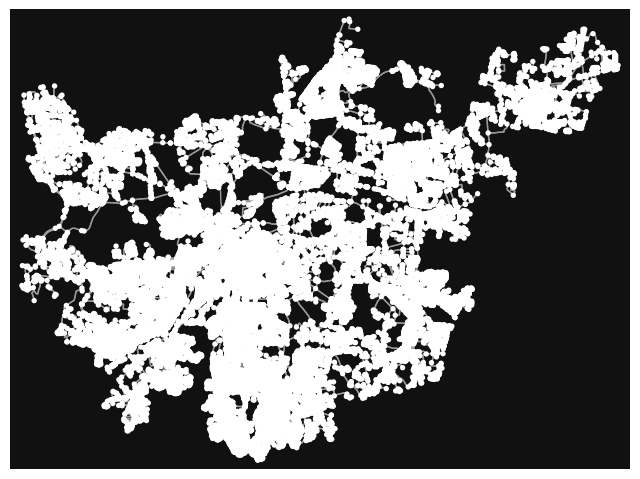

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
ox.plot_graph(graph)

**Routing**

In [11]:
#finding the shortest path by travel_time
orig_point = (18.591337006294108, 73.73889115252335)  # lat, lon for Shrimant Dagdusheth Halwai Ganpati Mandir
dest_point = (18.56034373321838, 73.82508047707717)  # lat, lon for pune station

orig = ox.distance.nearest_nodes(graph, orig_point[1], orig_point[0])  # lon, lat
dest = ox.distance.nearest_nodes(graph, dest_point[1], dest_point[0])

route = nx.shortest_path(graph, orig, dest, weight="travel_time")

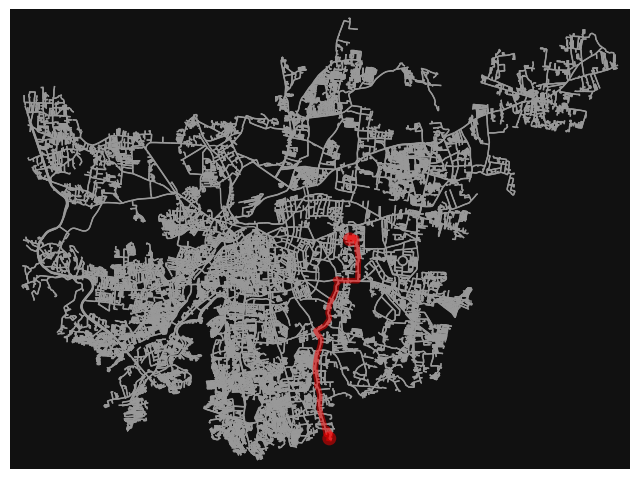

In [12]:
orig, dest = list(graph.nodes())[0], list(graph.nodes())[-1]
route = nx.shortest_path(graph, orig, dest, weight="travel_time")

fig, ax = ox.plot_graph_route(graph, route, node_size=0)

### Phase 3 – ML Component (Travel Time Estimation)

##### Goal- Estimate how long the above selected route will take using a regression model trained on features like:
- Road type
- Segment length
- Time of day
- Speed limit or average speed

In [36]:
#Feature Engineering: Extracting features from each edge in the route

edge_data=[]
for u, v in zip(route[:-1], route[1:]):
    data= graph[u][v][0]    
    edge_data.append({
        "length": data.get("length", 0),
        "highway":data.get("highway", "unclassified"),
        "maxspeed": data.get("maxspeed", None)
    })

In [37]:
df= pd.DataFrame(edge_data)

In [38]:
df.head()

,length,highway,maxspeed
0,43.192759,residential,None
1,42.289896,trunk,None
2,55.550940,trunk,None
3,74.759017,trunk,None
4,178.161884,tertiary,None


In [51]:
# add time features manually
df["hour"]= 13       # ex- morning rush hour
df["day_of_week"]= 5       # Tuesday

In [52]:
df["highway"].unique()

array(['residential', 'trunk', 'tertiary', 'trunk_link', 'primary',
       'secondary'], dtype=object)

**Mapping of Highway Type → Assumed Average Speed (km/h)**
| Highway Type    | Max Speed (per article)                                              | Assumed Avg Speed | Reasoning                                                                                                    |
| --------------- | -------------------------------------------------------------------- | ----------------- | ------------------------------------------------------------------------------------------------------------ |
| **residential** | 30 km/h (typical residential areas; article says 30–40 for built-up) | **25**            | Narrow lanes, parked vehicles, pedestrians, speed breakers; average will be well below limit.                |
| **trunk**       | 100 km/h (national highways)                                         | **60**            | Highways have high limits but inside/near cities, traffic and junctions reduce real speed drastically.       |
| **tertiary**    | 50–60 km/h (minor roads, connecting local areas)                     | **35**            | Moderate traffic, mixed use, not as congested as residential but not free-flowing.                           |
| **trunk\_link** | 80–100 km/h (short connectors to highways)                           | **50**            | Short distance, but often bottlenecked by merging traffic.                                                   |
| **primary**     | 80 km/h (state highways)                                             | **45**            | Major city roads; congestion + signals keep avg much lower.                                                  |
| **secondary**   | 60–70 km/h (smaller connecting roads)                                | **40**            | Less capacity than primary, slightly better than tertiary in some rural stretches but slower in urban areas. |


In [53]:
# assuming avg speed per highway type
speed_map= {
    "residential": 20,
    "trunk": 60,
    "teriary": 35, 
    "trunk_link": 50,
    "primary": 45, 
    "secondary": 40
}

In [54]:
df["speed_kmph"]= df["highway"].map(speed_map).fillna(30)
df["speed_mps"]= df["speed_kmph"]*(1000/3600)
df["travel_time_sec"]= df["length"]/df["speed_mps"]     # length is in meters

In [55]:
df.tail()

,length,highway,maxspeed,hour,day_of_week,speed_kmph,speed_mps,travel_time_sec
121,29.590934,tertiary,None,13,5,30.0,8.333333,3.550912
122,213.609682,tertiary,None,13,5,30.0,8.333333,25.633162
123,153.671415,residential,None,13,5,20.0,5.555556,27.660855
124,86.455415,residential,None,13,5,20.0,5.555556,15.561975
125,554.980709,residential,None,13,5,20.0,5.555556,99.896528


In [56]:
#total time (Estimated Time of Arrival) it takes to reach the destination
total_eta= df['travel_time_sec'].sum()
total_eta

np.float64(1274.086548391575)

In [57]:
#total distance
print("Total Distance: ", df['length'].sum()/1000)

Total Distance:  13.829671403819363


In [45]:
# Using regression to learn travel_time from feature
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [46]:
models= {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression": SVR(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Ada Boost Regressor": AdaBoostRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()
}

model_list=[]
r2_list=[]

In [47]:
X= df[["length", "hour", "day_of_week", "speed_mps"]]
Y= df["travel_time_sec"]

X_train, X_test, Y_train, Y_test= train_test_split(X, Y, random_state=42, train_size=0.7)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((88, 4), (38, 4), (88,), (38,))

In [48]:
def evaluate_model(true, predicted):
    mse= mean_squared_error(true, predicted)
    rmse= np.sqrt(mse)
    mae= mean_absolute_error(true, predicted)
    r2= r2_score(true, predicted)
    return rmse, mae, r2

In [49]:
for i in range(len(list(models))):
    model=list(models.values())[i]

    model.fit(X_train, Y_train)     #fit the model

    #make predictions
    Y_train_predict= model.predict(X_train)
    Y_test_predict= model.predict(X_test)

    #evaluate the train and test dataset
    model_train_mae, model_train_rmse, model_train_r2= evaluate_model(Y_train, Y_train_predict)
    model_test_mae, model_test_rmse, model_test_r2= evaluate_model(Y_test, Y_test_predict)

    #print results
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 2.4374
- Mean Absolute Error: 5.0030
- R2 Score: 0.9000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.1276
- Mean Absolute Error: 2.8949
- R2 Score: 0.8530


Support Vector Regression
Model performance for Training set
- Root Mean Squared Error: 3.9183
- Mean Absolute Error: 12.0796
- R2 Score: 0.4169
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.8238
- Mean Absolute Error: 3.4539
- R2 Score: 0.7907


Decision Tree Regressor
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.2982
- Mean Absolute Error: 2.9303
- R2 Score: 0.8494


Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 0.9283
- Mean Absolute Error: 2.9668
-

**Conclusion:**

Issues / Observations:

- Decision Tree is overfitting badly → Train R² = 1.0, Test R² drops. This is why a simple tree is risky without pruning.
- Gradient Boosting seems strongest → Test R² ≈ 0.94 and low RMSE/MAE.
- Linear Regression does surprisingly well (Test R² = 0.89) despite being simple — a good baseline.
- SVR has mediocre R² compared to others and slower runtime on bigger datasets.
- Random Forest is competitive (Test R² ≈ 0.90) but slower to train for very large graphs.

Selection approach:

- Taking low variance between Train and Test scores (low overfit) + best error metrics (RMSE, MAE) into account and not just highest r2 score.

- **Gradient Boosting** looks like the safest bet for Phase 3, with Random Forest as a fallback if interpretability is less important.

In [50]:
best_model= GradientBoostingRegressor()